## Importer librairies

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn import preprocessing
from sklearn import decomposition

In [2]:
#Gestion des options d'affichage 
pd.set_option('display.max_row',1000)
pd.set_option('display.max_columns',50)

## Charger les données

In [3]:
dispo =pd.read_csv('DisponibiliteAlimentaire_2017.csv', sep=',', usecols= ['Zone', 'Élément', 'Produit','Unité', 'Valeur'])

In [4]:
population = pd.read_csv('Population_2000_2018.csv', sep= ',',usecols= ['Zone','Année','Valeur'])

In [5]:
pib= pd.read_csv('PIB par habitant 2017.csv', sep= ',', usecols= ['Zone','Valeur'])

## Exploration des données

### Disponibilité pour l'année 2017

In [6]:
print("Shape: ", dispo.shape)
dispo.head()

Shape:  (176600, 5)


,Zone,Élément,Produit,Unité,Valeur
0,Afghanistan,Production,Blé et produits,Milliers de tonnes,4281.0
1,Afghanistan,Importations - Quantité,Blé et produits,Milliers de tonnes,2302.0
2,Afghanistan,Variation de stock,Blé et produits,Milliers de tonnes,-119.0
3,Afghanistan,Exportations - Quantité,Blé et produits,Milliers de tonnes,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,Milliers de tonnes,6701.0


In [7]:
dispo.describe()
# on trouve de valeurs négatives

,Valeur
count,176600.000000
mean,210.554918
std,4762.047787
min,-10388.000000
25%,0.000000
50%,0.120000
75%,8.462500
max,758548.000000


In [8]:
'''
Cette fonction permet de voir les valeurs nulls et uniques dans le df
'''
def voir_uniques_nulls(df):
    print("Valeurs uniques:\n",dispo.nunique() )
    print("_" * 20)
    print("Valeurs nulls:\n", dispo.isnull().sum())
    

In [9]:
voir_uniques_nulls(dispo)

Valeurs uniques:
 Zone        174
Élément      17
Produit      98
Unité         4
Valeur     7250
dtype: int64
____________________
Valeurs nulls:
 Zone       0
Élément    0
Produit    0
Unité      0
Valeur     0
dtype: int64


In [10]:
# Il y a 2 544 valeurs négatives
dispo[dispo['Valeur'] < 0].shape

(2544, 5)

In [11]:
# Eliminer les valeurs négatives
dispo.drop(dispo[dispo['Valeur'] < 0].index, inplace = True)

In [12]:
#Shape avant de drop (176600, 5)
dispo.shape

(174056, 5)

Je vais prendre juste les données pour le produit Viande de Volailles

In [13]:
#mask_1 pour filtrer les variables liées au viande de volailles
#'Importations - Quantité', 'Disponibilité alimentaire en quantité (kg/personne/an)'
#
mask_1 = ['Production', 'Importations - Quantité' ,'Exportations - Quantité']

In [14]:
dispo= dispo[(dispo[ "Produit" ] ==  'Viande de Volailles') & dispo[ "Élément"].isin(mask_1)]

In [15]:
dispo.shape

(473, 5)

In [16]:
dispo.head()

,Zone,Élément,Produit,Unité,Valeur
651,Afghanistan,Production,Viande de Volailles,Milliers de tonnes,28.0
652,Afghanistan,Importations - Quantité,Viande de Volailles,Milliers de tonnes,29.0
1704,Afrique du Sud,Production,Viande de Volailles,Milliers de tonnes,1667.0
1705,Afrique du Sud,Importations - Quantité,Viande de Volailles,Milliers de tonnes,514.0
1707,Afrique du Sud,Exportations - Quantité,Viande de Volailles,Milliers de tonnes,63.0


In [17]:
dispo.Unité.unique()

array(['Milliers de tonnes'], dtype=object)

In [18]:
vars_volailles = pd.pivot_table(dispo[["Zone","Élément","Valeur"]], index= ['Zone'], columns=['Élément']).reset_index( level= [0])

In [19]:
vars_volailles.head()

Zone                  Valeur                          \
Élément                 Exportations - Quantité Importations - Quantité   
0           Afghanistan                     NaN                    29.0   
1        Afrique du Sud                    63.0                   514.0   
2               Albanie                     0.0                    38.0   
3               Algérie                     0.0                     2.0   
4             Allemagne                   646.0                   842.0   

                    
Élément Production  
0             28.0  
1           1667.0  
2             13.0  
3            275.0  
4           1514.0

In [20]:
# droplevel, to transform pandas pivot table to regular dataframe

vars_volailles.columns = vars_volailles.columns.droplevel(0)
vars_volailles = vars_volailles.rename_axis(None, axis=1)

In [21]:
# Rénomer les colonnes
# , 'Importations - Quantité','Disponibilité alimentaire en quantité (kg/personne/an)'
#,'Exportations - Quantité'

vars_volailles.columns = ['Pays','Exportations - Quantité','Importations - Quantité',
                          'Production']

In [22]:
vars_volailles.head()

,Pays,Exportations - Quantité,Importations - Quantité,Production
0,Afghanistan,NaN,29.0,28.0
1,Afrique du Sud,63.0,514.0,1667.0
2,Albanie,0.0,38.0,13.0
3,Algérie,0.0,2.0,275.0
4,Allemagne,646.0,842.0,1514.0


In [23]:
print("Nombre de pays,", vars_volailles.shape[0])

Nombre de pays, 170


In [24]:
vars_volailles.describe()

,Exportations - Quantité,Importations - Quantité,Production
count,135.000000,170.000000,168.000000
mean,132.185185,89.529412,725.190476
std,513.784440,186.669983,2501.457125
min,0.000000,0.000000,0.000000
25%,0.000000,3.000000,13.750000
50%,3.000000,16.000000,70.000000
75%,32.000000,81.250000,409.750000
max,4223.000000,1069.000000,21914.000000


In [25]:

vars_volailles.isna().sum()

Pays                        0
Exportations - Quantité    35
Importations - Quantité     0
Production                  2
dtype: int64

*Taux de dépendance des importations (TDI)*:<br> Au cours de l'analyse de la situation alimentaire d'un pays, il importe de bien savoir quelle part les approvisionnements intérieurs disponibles provient des importations et quelle part provient de la production du pays lui-même. Le TDI répond à cette question. Il se définit ainsi:<br><br>
${TDI}=\frac{Importations}{Productions + Importations - Exportations}*100$


In [26]:
vars_volailles['TDI'] = (vars_volailles['Importations - Quantité']/
                         (vars_volailles['Production'] + 
                          vars_volailles['Importations - Quantité'] -
                         vars_volailles['Exportations - Quantité'])) * 100

In [27]:
vars_volailles.head()

,Pays,Exportations - Quantité,Importations - Quantité,Production,TDI
0,Afghanistan,NaN,29.0,28.0,NaN
1,Afrique du Sud,63.0,514.0,1667.0,24.268178
2,Albanie,0.0,38.0,13.0,74.509804
3,Algérie,0.0,2.0,275.0,0.722022
4,Allemagne,646.0,842.0,1514.0,49.239766


In [28]:
# Imputation par la moyenne

vars_volailles.fillna(vars_volailles.mean(),inplace= True)

### Population en 2017

Prendre la population de 2017 et l'évoultion de la population du 2000 et 2017. <br>
Unité: 1000 personnes

In [29]:
population.head()

,Zone,Année,Valeur
0,Afghanistan,2000,20779.953
1,Afghanistan,2001,21606.988
2,Afghanistan,2002,22600.770
3,Afghanistan,2003,23680.871
4,Afghanistan,2004,24726.684


In [30]:
population.shape

(4411, 3)

In [31]:
population.describe()

,Année,Valeur
count,4411.000000,4.411000e+03
mean,2009.068238,2.963004e+04
std,5.481539,1.238029e+05
min,2000.000000,7.850000e-01
25%,2004.000000,3.921890e+02
50%,2009.000000,4.764741e+03
75%,2014.000000,1.821548e+04
max,2018.000000,1.427648e+06


In [32]:
#Convertir la valeur 1000 personnes en personne 
population["Valeur"]= population["Valeur"]*1000

In [33]:
voir_uniques_nulls(population)

Valeurs uniques:
 Zone       170
Élément      3
Produit      1
Unité        1
Valeur     196
dtype: int64
____________________
Valeurs nulls:
 Zone       0
Élément    0
Produit    0
Unité      0
Valeur     0
dtype: int64


Evolution de la population de pays

In [34]:
evol_pop= pd.pivot_table(population, index= ['Zone'], columns=['Année']).reset_index( level= [0])

In [35]:
evol_pop.head()

Zone      Valeur                                      \
Année                        2000        2001        2002        2003   
0         Afghanistan  20779953.0  21606988.0  22600770.0  23680871.0   
1      Afrique du Sud  44967708.0  45571274.0  46150913.0  46719196.0   
2             Albanie   3129243.0   3129704.0   3126187.0   3118023.0   
3             Algérie  31042235.0  31451514.0  31855109.0  32264157.0   
4           Allemagne  81400882.0  81453885.0  81535122.0  81614380.0   

                                                                               \
Année        2004        2005        2006        2007        2008        2009   
0      24726684.0  25654277.0  26433049.0  27100536.0  27722276.0  28394813.0   
1      47291610.0  47880601.0  48489459.0  49119759.0  49779471.0  50477011.0   
2       3104892.0   3086810.0   3063021.0   3033998.0   3002678.0   2973048.0   
3      32692163.0  33149724.0  33641002.0  34166972.0  34730608.0  35333881.0   
4      81646474.0  81602741.0  81472226.0  81277830.0  81065752.0  80899961.0   

                                                                               \
Année        2010        2011        2012        2013        2014        2015   
0      29185507.0  30117413.0  31161376.0  32269589.0  33370794.0  34413603.0   
1      51216964.0  52003755.0  52832658.0  53687121.0  54544186.0  55386367.0   
2       2948023.0   2928592.0   2914096.0   2903790.0   2896305.0   2890513.0   
3      35977455.0  36661445.0  37383895.0  38140133.0  38923692.0  39728025.0   
4      80827002.0  80855632.0  80972628.0  81174367.0  81450378.0  81787411.0   

                                           
Année        2016        2017        2018  
0      35383032.0  36296113.0  37171921.0  
1      56207646.0  57009756.0  57792518.0  
2       2886438.0   2884169.0   2882740.0  
3      40551392.0  41389189.0  42228408.0  
4      82193768.0  82658409.0  83124418.0

In [36]:
# droplevel, to transform pandas pivot table to regular dataframe
def regular_df(df):
    df.columns = df.columns.droplevel(0)
    df = df.rename_axis(None, axis=1)

In [37]:
regular_df(evol_pop)

In [38]:
evol_pop.head()

Année,,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383032.0,36296113.0,37171921.0
1,Afrique du Sud,44967708.0,45571274.0,46150913.0,46719196.0,47291610.0,47880601.0,48489459.0,49119759.0,49779471.0,50477011.0,51216964.0,52003755.0,52832658.0,53687121.0,54544186.0,55386367.0,56207646.0,57009756.0,57792518.0
2,Albanie,3129243.0,3129704.0,3126187.0,3118023.0,3104892.0,3086810.0,3063021.0,3033998.0,3002678.0,2973048.0,2948023.0,2928592.0,2914096.0,2903790.0,2896305.0,2890513.0,2886438.0,2884169.0,2882740.0
3,Algérie,31042235.0,31451514.0,31855109.0,32264157.0,32692163.0,33149724.0,33641002.0,34166972.0,34730608.0,35333881.0,35977455.0,36661445.0,37383895.0,38140133.0,38923692.0,39728025.0,40551392.0,41389189.0,42228408.0
4,Allemagne,81400882.0,81453885.0,81535122.0,81614380.0,81646474.0,81602741.0,81472226.0,81277830.0,81065752.0,80899961.0,80827002.0,80855632.0,80972628.0,81174367.0,81450378.0,81787411.0,82193768.0,82658409.0,83124418.0


In [39]:
n_cols=[]

In [40]:
# Rénomer les colonnes

for col in evol_pop.columns:
    if col== '':
        n_cols.append("Pays")
    else:
        n_cols.append(str(col))

print(n_cols)

['Pays', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


In [41]:
evol_pop.columns = n_cols
evol_pop.head()

,Pays,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383032.0,36296113.0,37171921.0
1,Afrique du Sud,44967708.0,45571274.0,46150913.0,46719196.0,47291610.0,47880601.0,48489459.0,49119759.0,49779471.0,50477011.0,51216964.0,52003755.0,52832658.0,53687121.0,54544186.0,55386367.0,56207646.0,57009756.0,57792518.0
2,Albanie,3129243.0,3129704.0,3126187.0,3118023.0,3104892.0,3086810.0,3063021.0,3033998.0,3002678.0,2973048.0,2948023.0,2928592.0,2914096.0,2903790.0,2896305.0,2890513.0,2886438.0,2884169.0,2882740.0
3,Algérie,31042235.0,31451514.0,31855109.0,32264157.0,32692163.0,33149724.0,33641002.0,34166972.0,34730608.0,35333881.0,35977455.0,36661445.0,37383895.0,38140133.0,38923692.0,39728025.0,40551392.0,41389189.0,42228408.0
4,Allemagne,81400882.0,81453885.0,81535122.0,81614380.0,81646474.0,81602741.0,81472226.0,81277830.0,81065752.0,80899961.0,80827002.0,80855632.0,80972628.0,81174367.0,81450378.0,81787411.0,82193768.0,82658409.0,83124418.0


In [42]:
print("Nombre de pays,", evol_pop.shape[0])

Nombre de pays, 238


Aditioner le pourcentage de l'évolution de la population entre 2000 et 2017

In [43]:
evol_pop["p_evol"] = round(( evol_pop['2017'] - evol_pop['2014'])*100/ evol_pop['2014'], 2)

In [44]:
evol_pop.head()

,Pays,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,p_evol
0,Afghanistan,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383032.0,36296113.0,37171921.0,8.77
1,Afrique du Sud,44967708.0,45571274.0,46150913.0,46719196.0,47291610.0,47880601.0,48489459.0,49119759.0,49779471.0,50477011.0,51216964.0,52003755.0,52832658.0,53687121.0,54544186.0,55386367.0,56207646.0,57009756.0,57792518.0,4.52
2,Albanie,3129243.0,3129704.0,3126187.0,3118023.0,3104892.0,3086810.0,3063021.0,3033998.0,3002678.0,2973048.0,2948023.0,2928592.0,2914096.0,2903790.0,2896305.0,2890513.0,2886438.0,2884169.0,2882740.0,-0.42
3,Algérie,31042235.0,31451514.0,31855109.0,32264157.0,32692163.0,33149724.0,33641002.0,34166972.0,34730608.0,35333881.0,35977455.0,36661445.0,37383895.0,38140133.0,38923692.0,39728025.0,40551392.0,41389189.0,42228408.0,6.33
4,Allemagne,81400882.0,81453885.0,81535122.0,81614380.0,81646474.0,81602741.0,81472226.0,81277830.0,81065752.0,80899961.0,80827002.0,80855632.0,80972628.0,81174367.0,81450378.0,81787411.0,82193768.0,82658409.0,83124418.0,1.48


### Pib en 2017

Unité US$ 	par habitant

In [45]:
pib.head()

,Zone,Valeur
0,Pays-Bas (Royaume des),55088.6
1,Afghanistan,2058.4
2,Afrique du Sud,13860.3
3,Albanie,12771.0
4,Algérie,11737.4


In [46]:
pib.shape

(187, 2)

In [47]:
print("Nombre de pays: ", pib.shape[0])

Nombre de pays:  187


In [48]:
pib.columns = ["Pays", "Valeur US"]

In [49]:
pib.describe()

,Valeur US
count,187.000000
mean,20925.340642
std,22086.259174
min,773.600000
25%,4862.700000
50%,13102.100000
75%,29087.350000
max,126144.000000


## Construir le df final

Les variables à utiliser:
* Importation de viande de volailles
* Production de viande de volailles
* TDI
* Evolution de la population entre 2000 et 2017
* PIB 2017 (Valeur US $ par habitant)

In [50]:
vars_pays = pd.merge(
                    pd.merge(vars_volailles, evol_pop[['Pays','2017','p_evol']], on='Pays', how= 'inner'),
                    pib ,on= 'Pays', how='inner'
                    )

In [51]:
vars_pays.head()

,Pays,Exportations - Quantité,Importations - Quantité,Production,TDI,2017,p_evol,Valeur US
0,Afghanistan,132.185185,29.0,28.0,38.284057,36296113.0,8.77,2058.4
1,Afrique du Sud,63.000000,514.0,1667.0,24.268178,57009756.0,4.52,13860.3
2,Albanie,0.000000,38.0,13.0,74.509804,2884169.0,-0.42,12771.0
3,Algérie,0.000000,2.0,275.0,0.722022,41389189.0,6.33,11737.4
4,Allemagne,646.000000,842.0,1514.0,49.239766,82658409.0,1.48,53071.5


In [52]:
vars_pays.columns = ['Pays','Exportations',
                     'Importations', 'Production', 'TDI','Population_2017', 
                     'Evolution_pop', 'PIB_2017']

In [53]:
vars_pays.head()

,Pays,Exportations,Importations,Production,TDI,Population_2017,Evolution_pop,PIB_2017
0,Afghanistan,132.185185,29.0,28.0,38.284057,36296113.0,8.77,2058.4
1,Afrique du Sud,63.000000,514.0,1667.0,24.268178,57009756.0,4.52,13860.3
2,Albanie,0.000000,38.0,13.0,74.509804,2884169.0,-0.42,12771.0
3,Algérie,0.000000,2.0,275.0,0.722022,41389189.0,6.33,11737.4
4,Allemagne,646.000000,842.0,1514.0,49.239766,82658409.0,1.48,53071.5


J'ai utilisé inner join pour prendre que les pays qui consomment viande de volailles, donc j'obtien les 161 pays.

In [54]:
vars_pays.shape

(161, 8)

In [55]:
vars_pays.columns

Index(['Pays', 'Exportations', 'Importations', 'Production', 'TDI',
       'Population_2017', 'Evolution_pop', 'PIB_2017'],
      dtype='object')

In [56]:
vars_pays.shape

(161, 8)

In [57]:
vars_pays.head()

,Pays,Exportations,Importations,Production,TDI,Population_2017,Evolution_pop,PIB_2017
0,Afghanistan,132.185185,29.0,28.0,38.284057,36296113.0,8.77,2058.4
1,Afrique du Sud,63.000000,514.0,1667.0,24.268178,57009756.0,4.52,13860.3
2,Albanie,0.000000,38.0,13.0,74.509804,2884169.0,-0.42,12771.0
3,Algérie,0.000000,2.0,275.0,0.722022,41389189.0,6.33,11737.4
4,Allemagne,646.000000,842.0,1514.0,49.239766,82658409.0,1.48,53071.5


Df avec Importatios,Production, TDI, Evolution de la population, PIB en 2017

In [58]:
vars_pays.columns

Index(['Pays', 'Exportations', 'Importations', 'Production', 'TDI',
       'Population_2017', 'Evolution_pop', 'PIB_2017'],
      dtype='object')

In [59]:
df_5_vars = vars_pays[ ['Pays','Importations', 'Production', 'TDI','Evolution_pop', 'PIB_2017']]

In [60]:
df_5_vars.head()

,Pays,Importations,Production,TDI,Evolution_pop,PIB_2017
0,Afghanistan,29.0,28.0,38.284057,8.77,2058.4
1,Afrique du Sud,514.0,1667.0,24.268178,4.52,13860.3
2,Albanie,38.0,13.0,74.509804,-0.42,12771.0
3,Algérie,2.0,275.0,0.722022,6.33,11737.4
4,Allemagne,842.0,1514.0,49.239766,1.48,53071.5


In [61]:
df_5_vars.shape

(161, 6)

### Outliers

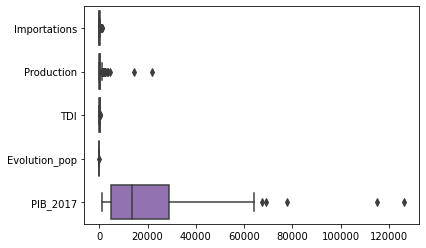

In [62]:
ax = sns.boxplot(data=df_5_vars, orient='h')

plt.rcParams["figure.dpi"] = 500
#plt.xlabel("Subjects", size=12)
#plt.ylabel("Test Scores", size=12)
plt.show()

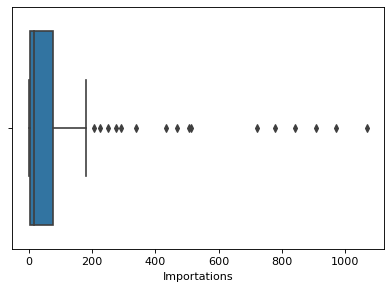

In [63]:
figure(figsize=(6, 4), dpi=80)
sns.boxplot(x=df_5_vars["Importations"])
plt.show()

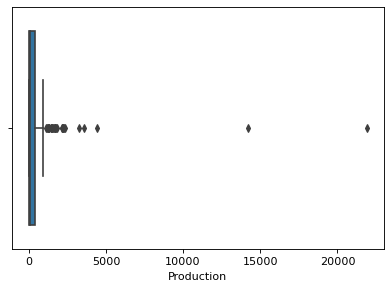

In [64]:
figure(figsize=(6, 4), dpi=80)
sns.boxplot(x=df_5_vars["Production"])
plt.show()

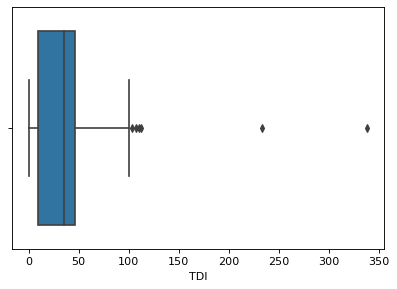

In [65]:
figure(figsize=(6, 4), dpi=80)
sns.boxplot(x=df_5_vars["TDI"])
plt.show()

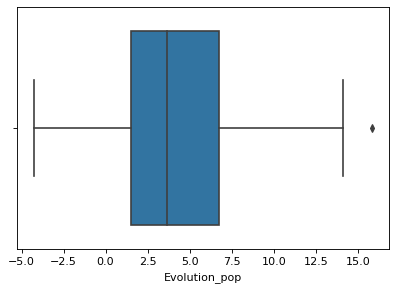

In [66]:
figure(figsize=(6, 4), dpi=80)
sns.boxplot(x=df_5_vars["Evolution_pop"])
plt.show()

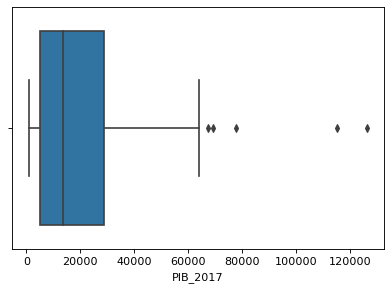

In [67]:
figure(figsize=(6, 4), dpi=80)
sns.boxplot(x=df_5_vars["PIB_2017"])
plt.show()

In [68]:
def outliers(df, col):
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    #create conditions to isolate the outliers
    # (vars_pays["Variation de stock"] < lower_bound) |
    outliers = df[ (col > upper_bound)]
    
    return outliers

In [69]:
out_impor= outliers(df_5_vars, df_5_vars["Importations"])
out_impor[['Pays','Importations']].sort_values(by = 'Importations', ascending = False)

,Pays,Importations
72,Japon,1069.0
95,Mexique,972.0
31,Chine - RAS de Hong-Kong,907.0
4,Allemagne,842.0
117,Royaume-Uni de Grande-Bretagne et d'Irlande du...,779.0
7,Arabie saoudite,722.0
1,Afrique du Sud,514.0
48,France,506.0
66,Iraq,470.0
156,Émirats arabes unis,433.0


In [70]:
out_prod= outliers(df_5_vars, df_5_vars["Production"])
out_prod[['Pays','Production']].sort_values(by = 'Production', ascending = False)

,Pays,Production
158,États-Unis d'Amérique,21914.0
21,Brésil,14201.0
49,Fédération de Russie,4444.0
63,Inde,3545.0
95,Mexique,3249.0
113,Pologne,2351.0
64,Indonésie,2301.0
72,Japon,2215.0
148,Turquie,2192.0
65,Iran (République islamique d'),2174.0


In [71]:
out_tdi= outliers(df_5_vars, df_5_vars["TDI"])
out_tdi[['Pays','TDI']].sort_values(by = 'TDI', ascending = False)

,Pays,TDI
31,Chine - RAS de Hong-Kong,338.432836
16,Belgique,233.103448
156,Émirats arabes unis,111.886305
84,Luxembourg,110.000000
107,Oman,107.692308
100,Namibie,103.571429


In [72]:
out_evol= outliers(df_5_vars, df_5_vars["Evolution_pop"])
out_evol[['Pays','Evolution_pop']].sort_values(by = 'Evolution_pop', ascending = False)

,Pays,Evolution_pop
107,Oman,15.86


In [73]:
out_pib= outliers(df_5_vars, df_5_vars["PIB_2017"])
out_pib[['Pays','PIB_2017']].sort_values(by = 'PIB_2017', ascending = False)

,Pays,PIB_2017
32,Chine - RAS de Macao,126144.0
84,Luxembourg,114986.0
67,Irlande,77749.2
135,Suisse,69103.6
156,Émirats arabes unis,67183.6


In [74]:
outliers_pays= ["Japon", "Mexique", "États-Unis d'Amérique", "Brésil","Chine - RAS de Hong-Kong",
               "Chine - RAS de Macao", "Luxembourg"]

In [75]:
print("Nombre des pays avant éliminer les outliers: ",df_5_vars.shape[0] )

Nombre des pays avant éliminer les outliers:  161


In [76]:
# Eliminer les pays outliers

df_5_vars = df_5_vars.drop(df_5_vars[df_5_vars.Pays.isin(outliers_pays)].index)

In [77]:
print("Nombre des pays après éliminer les outliers: ",df_5_vars.shape[0] )

Nombre des pays après éliminer les outliers:  154


In [78]:
df_5_vars.head()

,Pays,Importations,Production,TDI,Evolution_pop,PIB_2017
0,Afghanistan,29.0,28.0,38.284057,8.77,2058.4
1,Afrique du Sud,514.0,1667.0,24.268178,4.52,13860.3
2,Albanie,38.0,13.0,74.509804,-0.42,12771.0
3,Algérie,2.0,275.0,0.722022,6.33,11737.4
4,Allemagne,842.0,1514.0,49.239766,1.48,53071.5


In [79]:
# Mettre la colonne Pays comme index

df_5_vars = df_5_vars.set_index('Pays')

In [80]:
# Sauvegarder le dataframe
df_5_vars.to_csv('vollailles.csv')

In [81]:
df_5_vars.head()

,Importations,Production,TDI,Evolution_pop,PIB_2017
Pays,,,,,
Afghanistan,29.0,28.0,38.284057,8.77,2058.4
Afrique du Sud,514.0,1667.0,24.268178,4.52,13860.3
Albanie,38.0,13.0,74.509804,-0.42,12771.0
Algérie,2.0,275.0,0.722022,6.33,11737.4
Allemagne,842.0,1514.0,49.239766,1.48,53071.5


## ACP

In [82]:
# transformer les données en array numpy

X = df_5_vars.values

In [83]:
# Standariser les données

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [84]:
# Calcul des composantes pricipales

pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

Variance expliquée:
L'objet pca comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (explained_variance_ - proportionnelles aux valeurs propres) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (explained_variance_ratio_).

In [85]:
print(pca.explained_variance_)

[1.78979115 1.35898094 1.00418912 0.50659054 0.37312799]


In [86]:
print(pca.explained_variance_ratio_)

[0.35563383 0.27003128 0.19953368 0.1006602  0.07414102]


In [87]:
print(pca.explained_variance_ratio_.cumsum())

[0.35563383 0.6256651  0.82519879 0.92585898 1.        ]


Tableau récapitulatif, avec les variances expliquées, les proportions de variance expliquée simples et cumulées.

In [88]:
var_expl = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(5)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)

var_expl


,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,1.789791,36.0,36.0
1,Dim2,1.358981,27.0,63.0
2,Dim3,1.004189,20.0,83.0
3,Dim4,0.506591,10.0,93.0
4,Dim5,0.373128,7.0,100.0


 Représentation graphique de proportions de variances expliquées

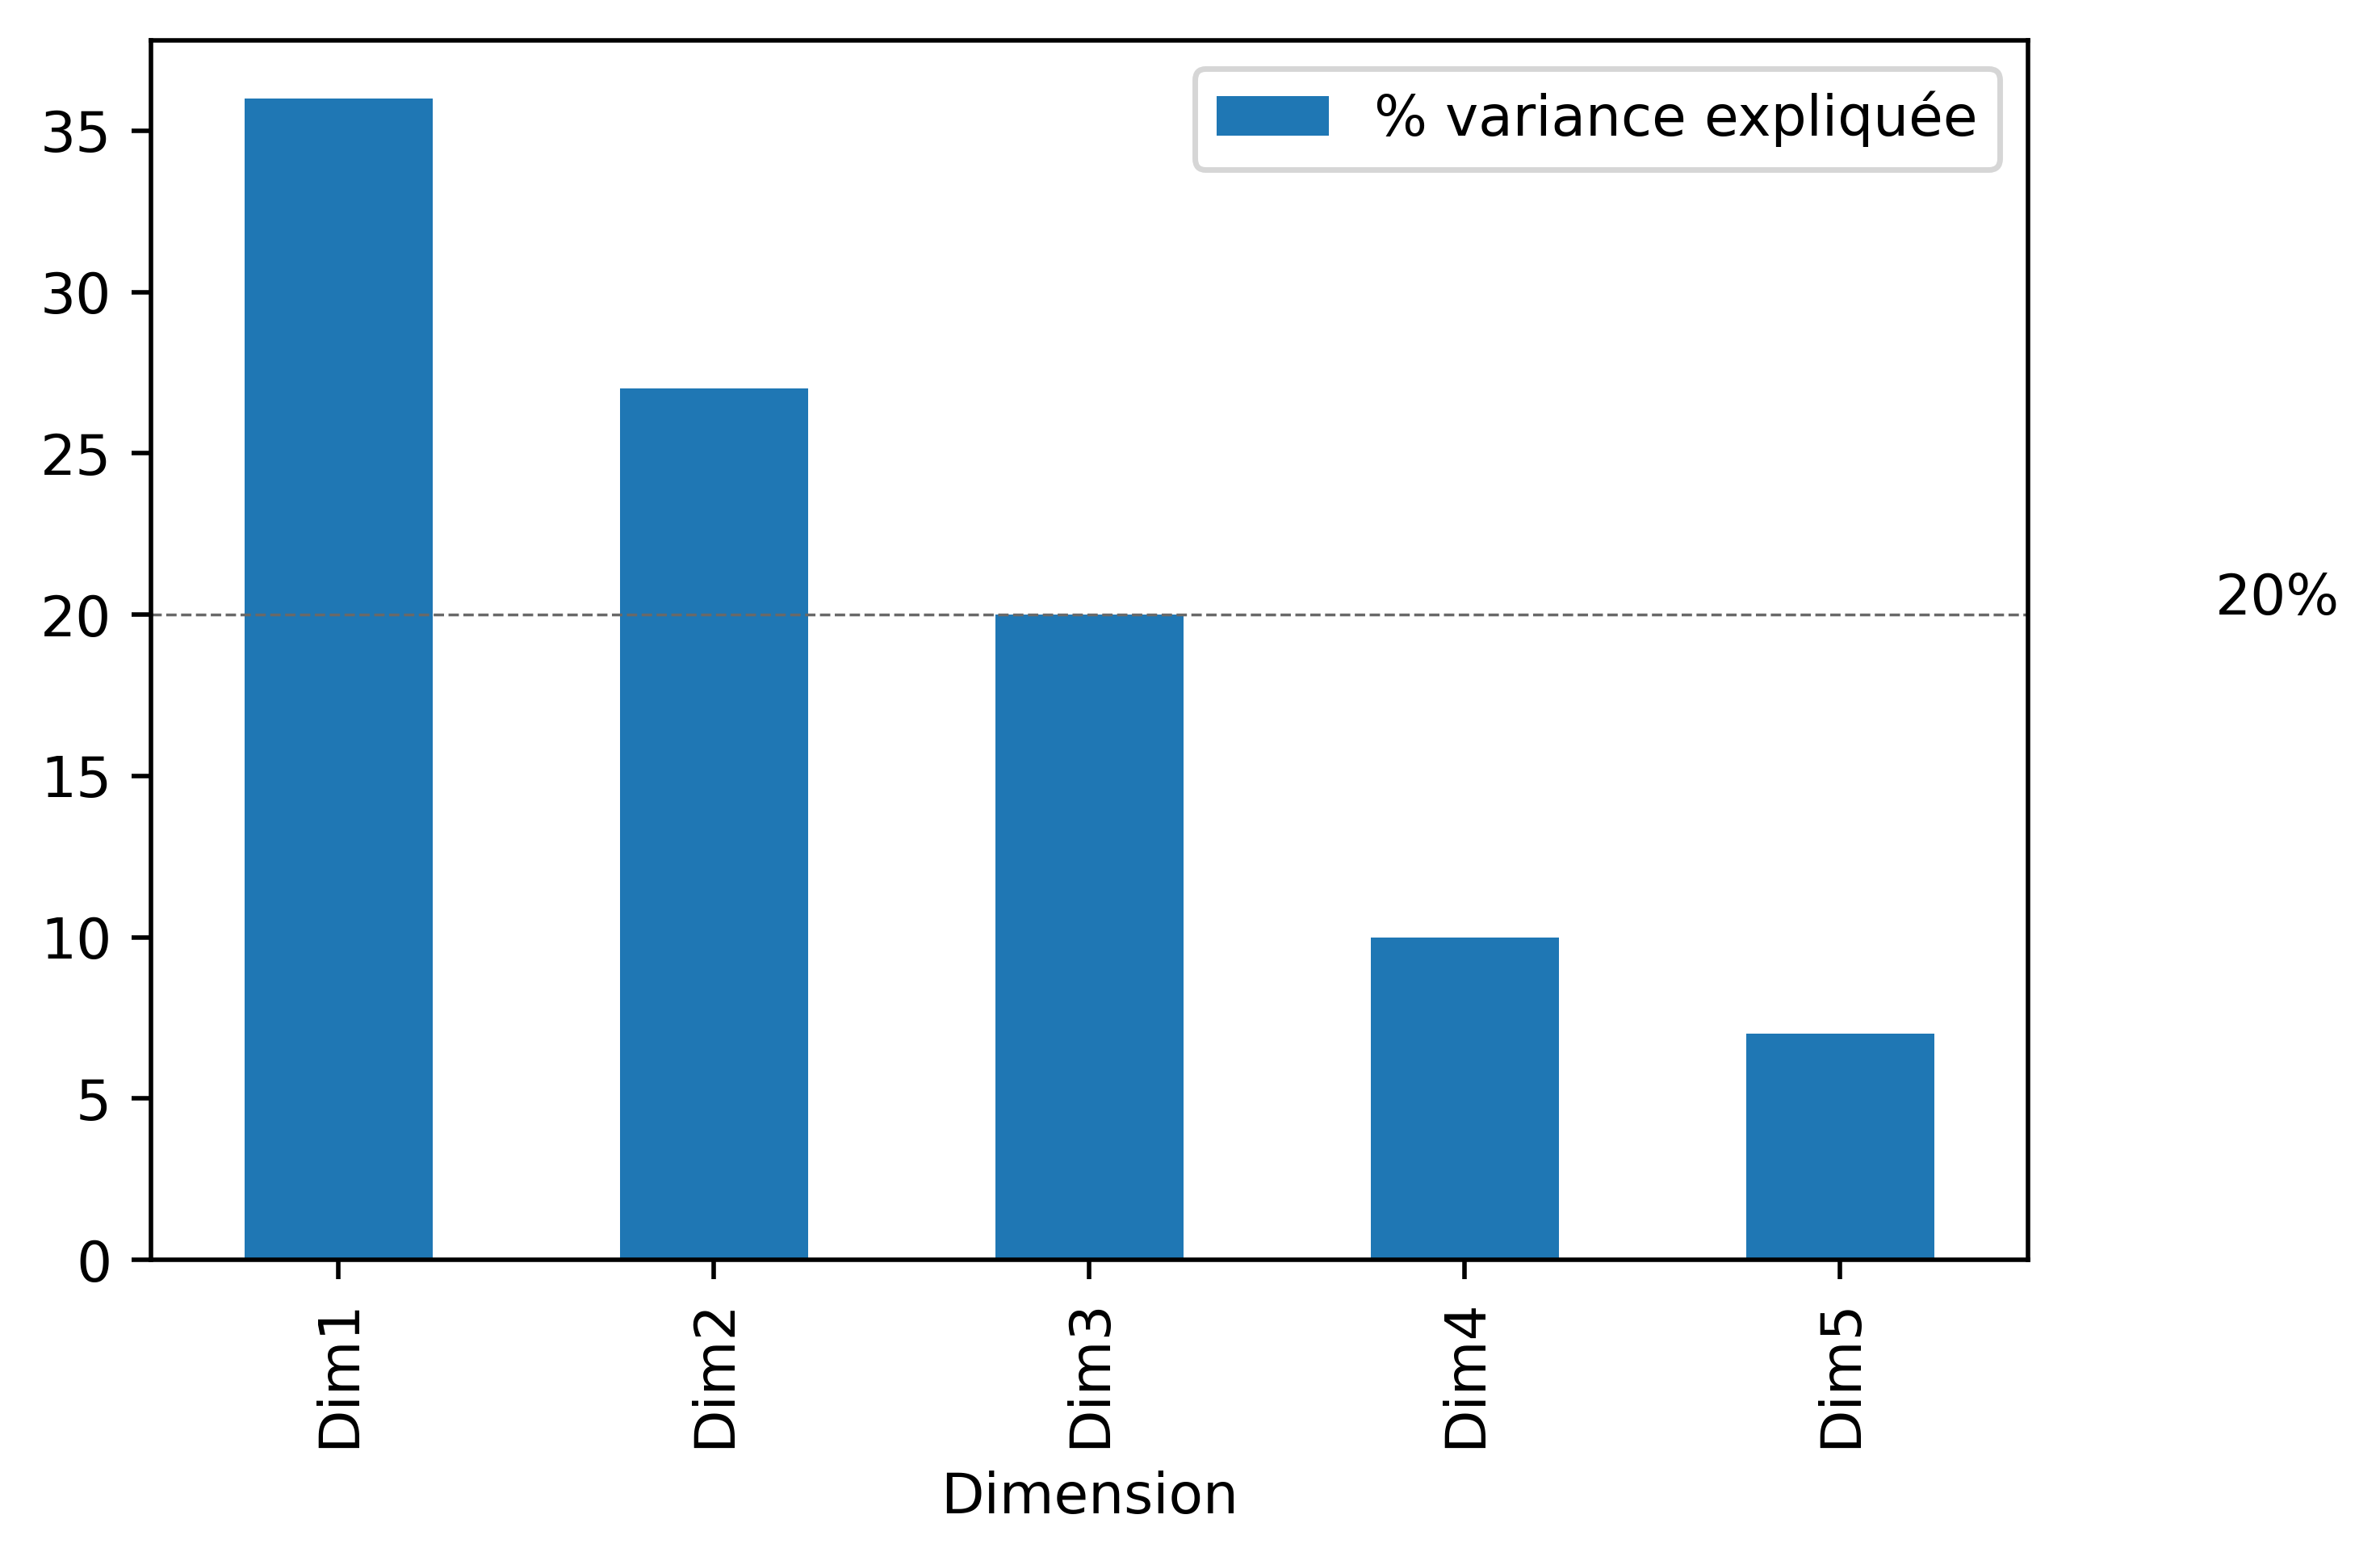

In [89]:
var_expl.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 20, "20%") # ajout de texte
plt.axhline(y = 20, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 14 = 100 / 7 (nb dimensions)
plt.show()

3 dimensions expliquent 83 % de la variance des données.

Représentation des individus:
Calculer les coordonnées des pays sur les dimensions, avec la fonction transform() de l'objet pca

In [90]:
X_projected = pca.transform(X_scaled)
X_projected.shape

(154, 5)

In [91]:
# Transformation en DataFrame pandas
projected_df = pd.DataFrame({
    "Dim1" : X_projected[:,0], 
    "Dim2" : X_projected[:,1],
    "Pays" : df_5_vars.index
})

# Résultat (premières lignes)
projected_df.head()

,Dim1,Dim2,Pays
0,-1.483437,0.268937,Afghanistan
1,2.170711,-0.651809,Afrique du Sud
2,0.130678,0.960287,Albanie
3,-0.903213,-0.796826,Algérie
4,5.154111,0.810301,Allemagne


Il est maintenant possible de représenter les données sur le premier plan factoriel. Dans ce graphique, il est important de noter le pourcentage de variance expliquée.

In [92]:
fig= plt.figure(figsize= (15,15))
plt.scatter(projected_df.Dim1, projected_df.Dim2)

for i, (x,y) in enumerate(zip(projected_df.Dim1, projected_df.Dim2 )):
    plt.text(x,y, df_5_vars.index[i])
    
plt.xlabel("Dimension 1 (36%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2 (27%)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (63%)") # titre général
plt.show()

Noms des pays ayant des valeurs absolues élevées pour chaque composante.

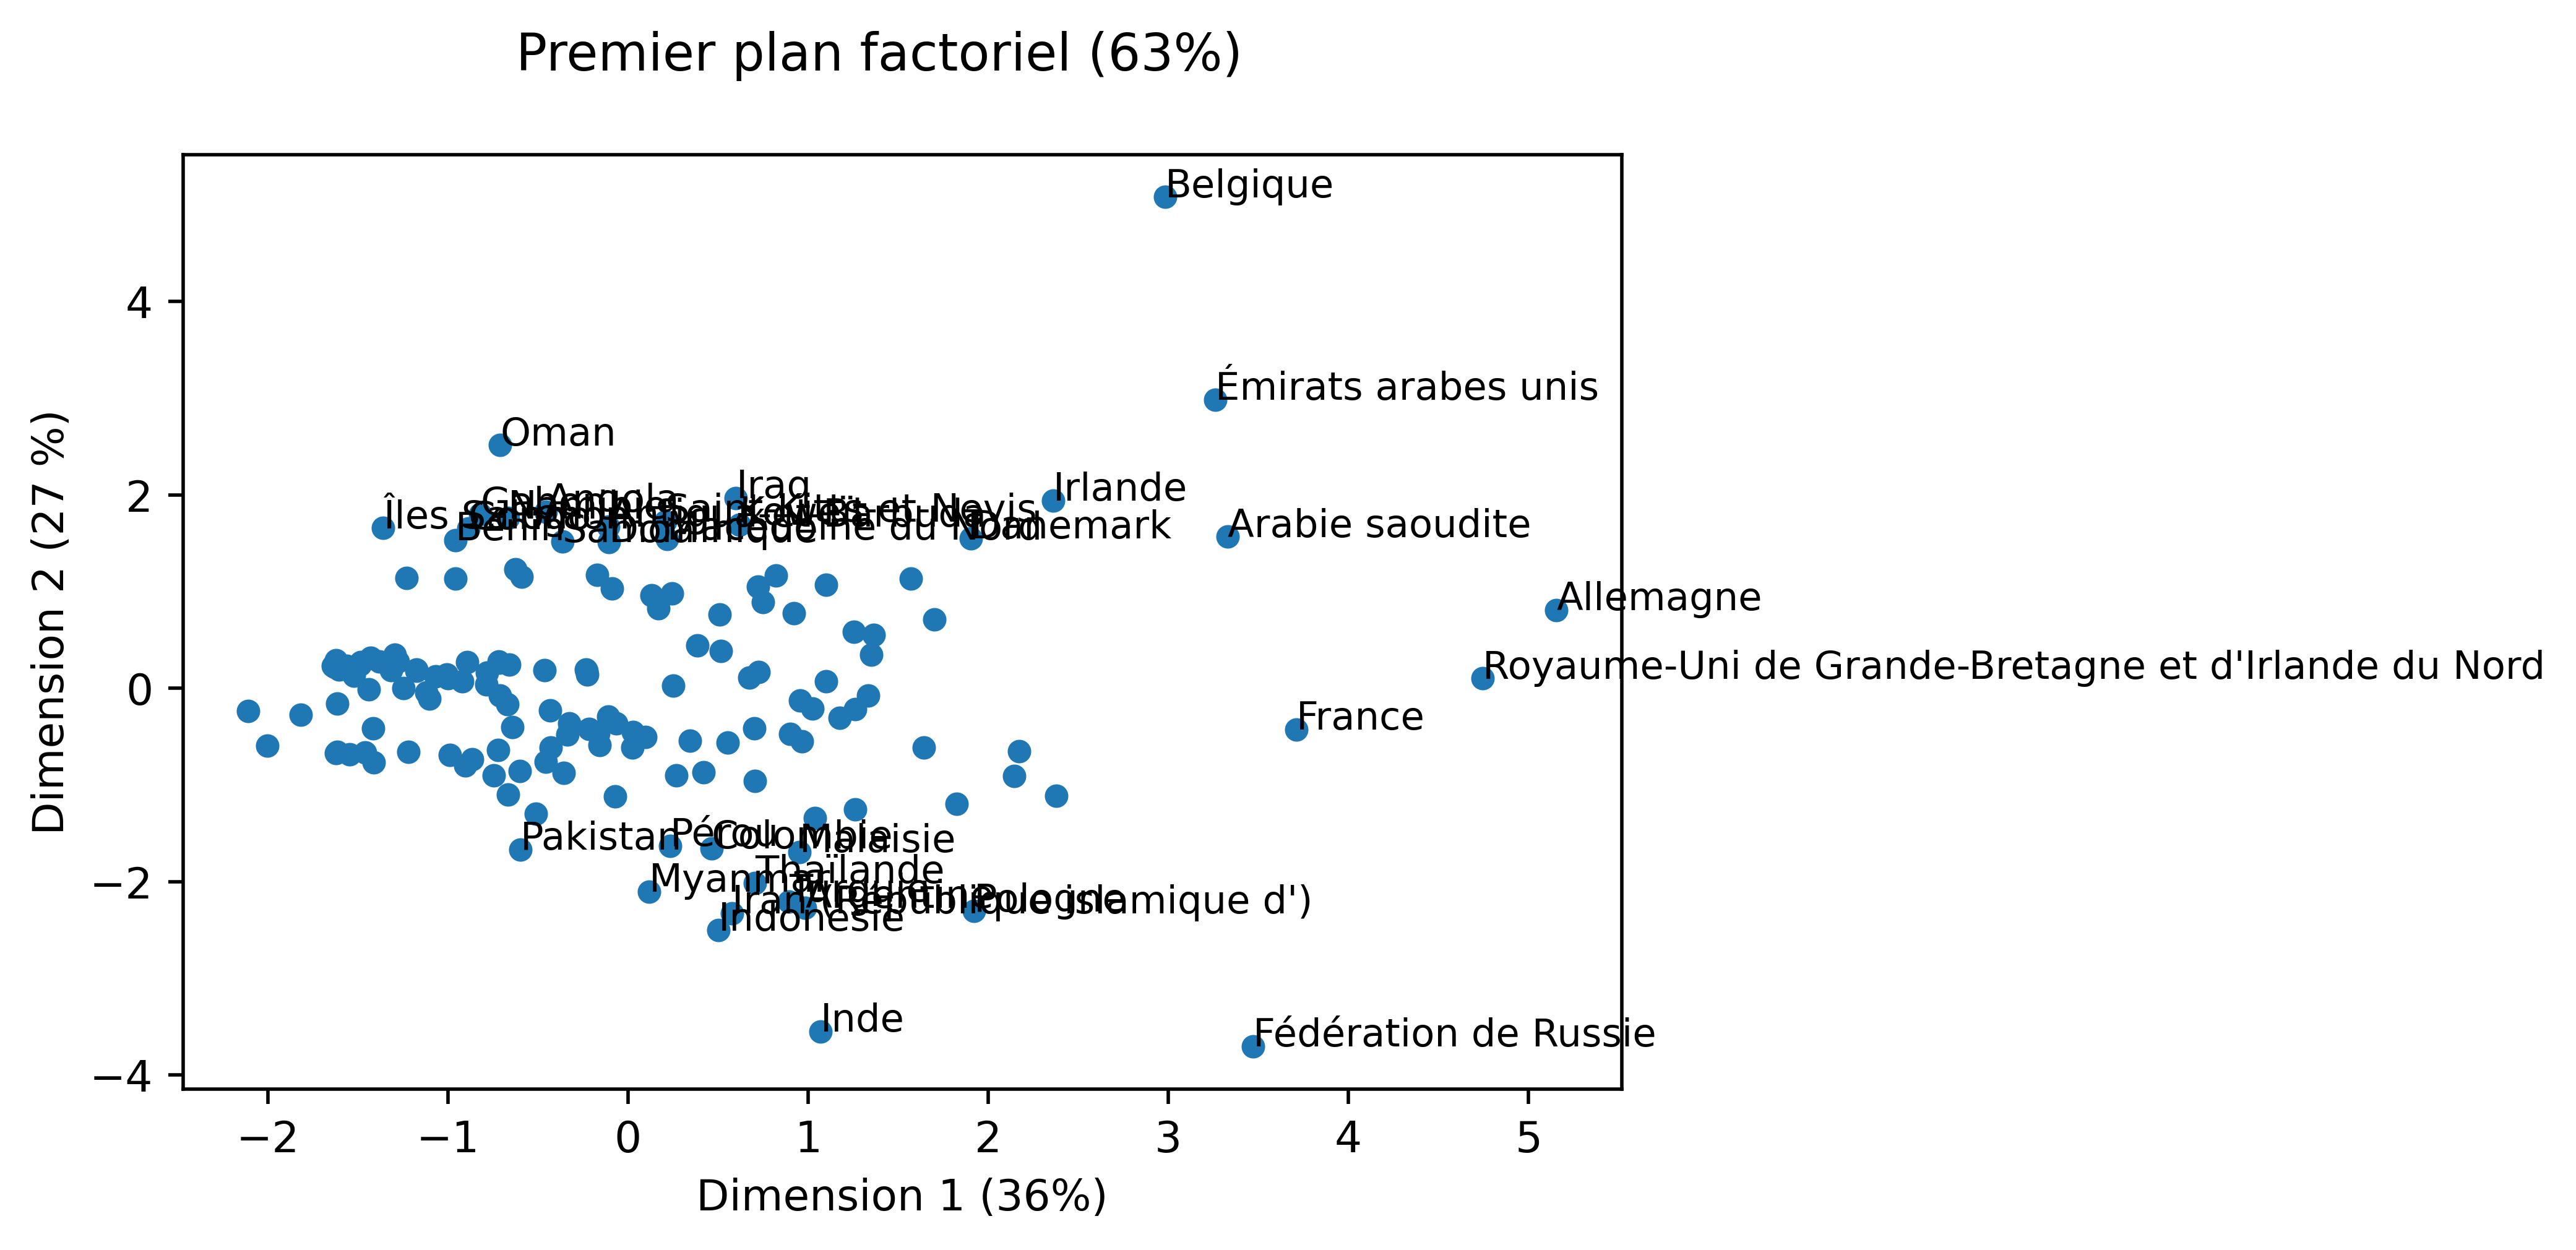

In [93]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots()
projected_df.plot.scatter("Dim1", "Dim2", ax = ax) # l'option ax permet de placer les points et le texte sur le même graphique

# boucle sur chaque pays
for k in projected_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['Dim1']) > 3.5) | (abs(k[1]['Dim2']) > 1.5):
        ax.annotate(k[1]["Pays"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1 (36%)") 
plt.ylabel("Dimension 2 (27 %)")
plt.suptitle("Premier plan factoriel (63%)")
plt.show()

### Représentation des variables

Lorsqu'on réalise une ACP, surtout dans un contexte exploratoire (et non de compression), il est absolument nécessaire de décrire les axes à partir des variables, afin de comprendre ce qu'ils représentent. Pour cela, nous devons réaliser le cercle des corrélations.

In [94]:
vars_pays.shape

(161, 8)

In [95]:
n = df_5_vars.shape[0] # nb individus
p = df_5_vars.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': df_5_vars.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar


,id,COR_1,COR_2
0,Importations,0.697783,0.231675
1,Production,0.527269,-0.656690
2,TDI,0.113086,0.901559
3,Evolution_pop,-0.595772,0.122327
4,PIB_2017,0.803444,0.193565


### Cercle de corrélations

Une fois ces coordonnées récupérées, on peut donc afficher ce cercle des corrélations comme ci-dessous.

In [96]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(8, 7))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # 
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [97]:
x_y = (0,1)
x_y

(0, 1)

In [98]:
features = coordvar["id"]

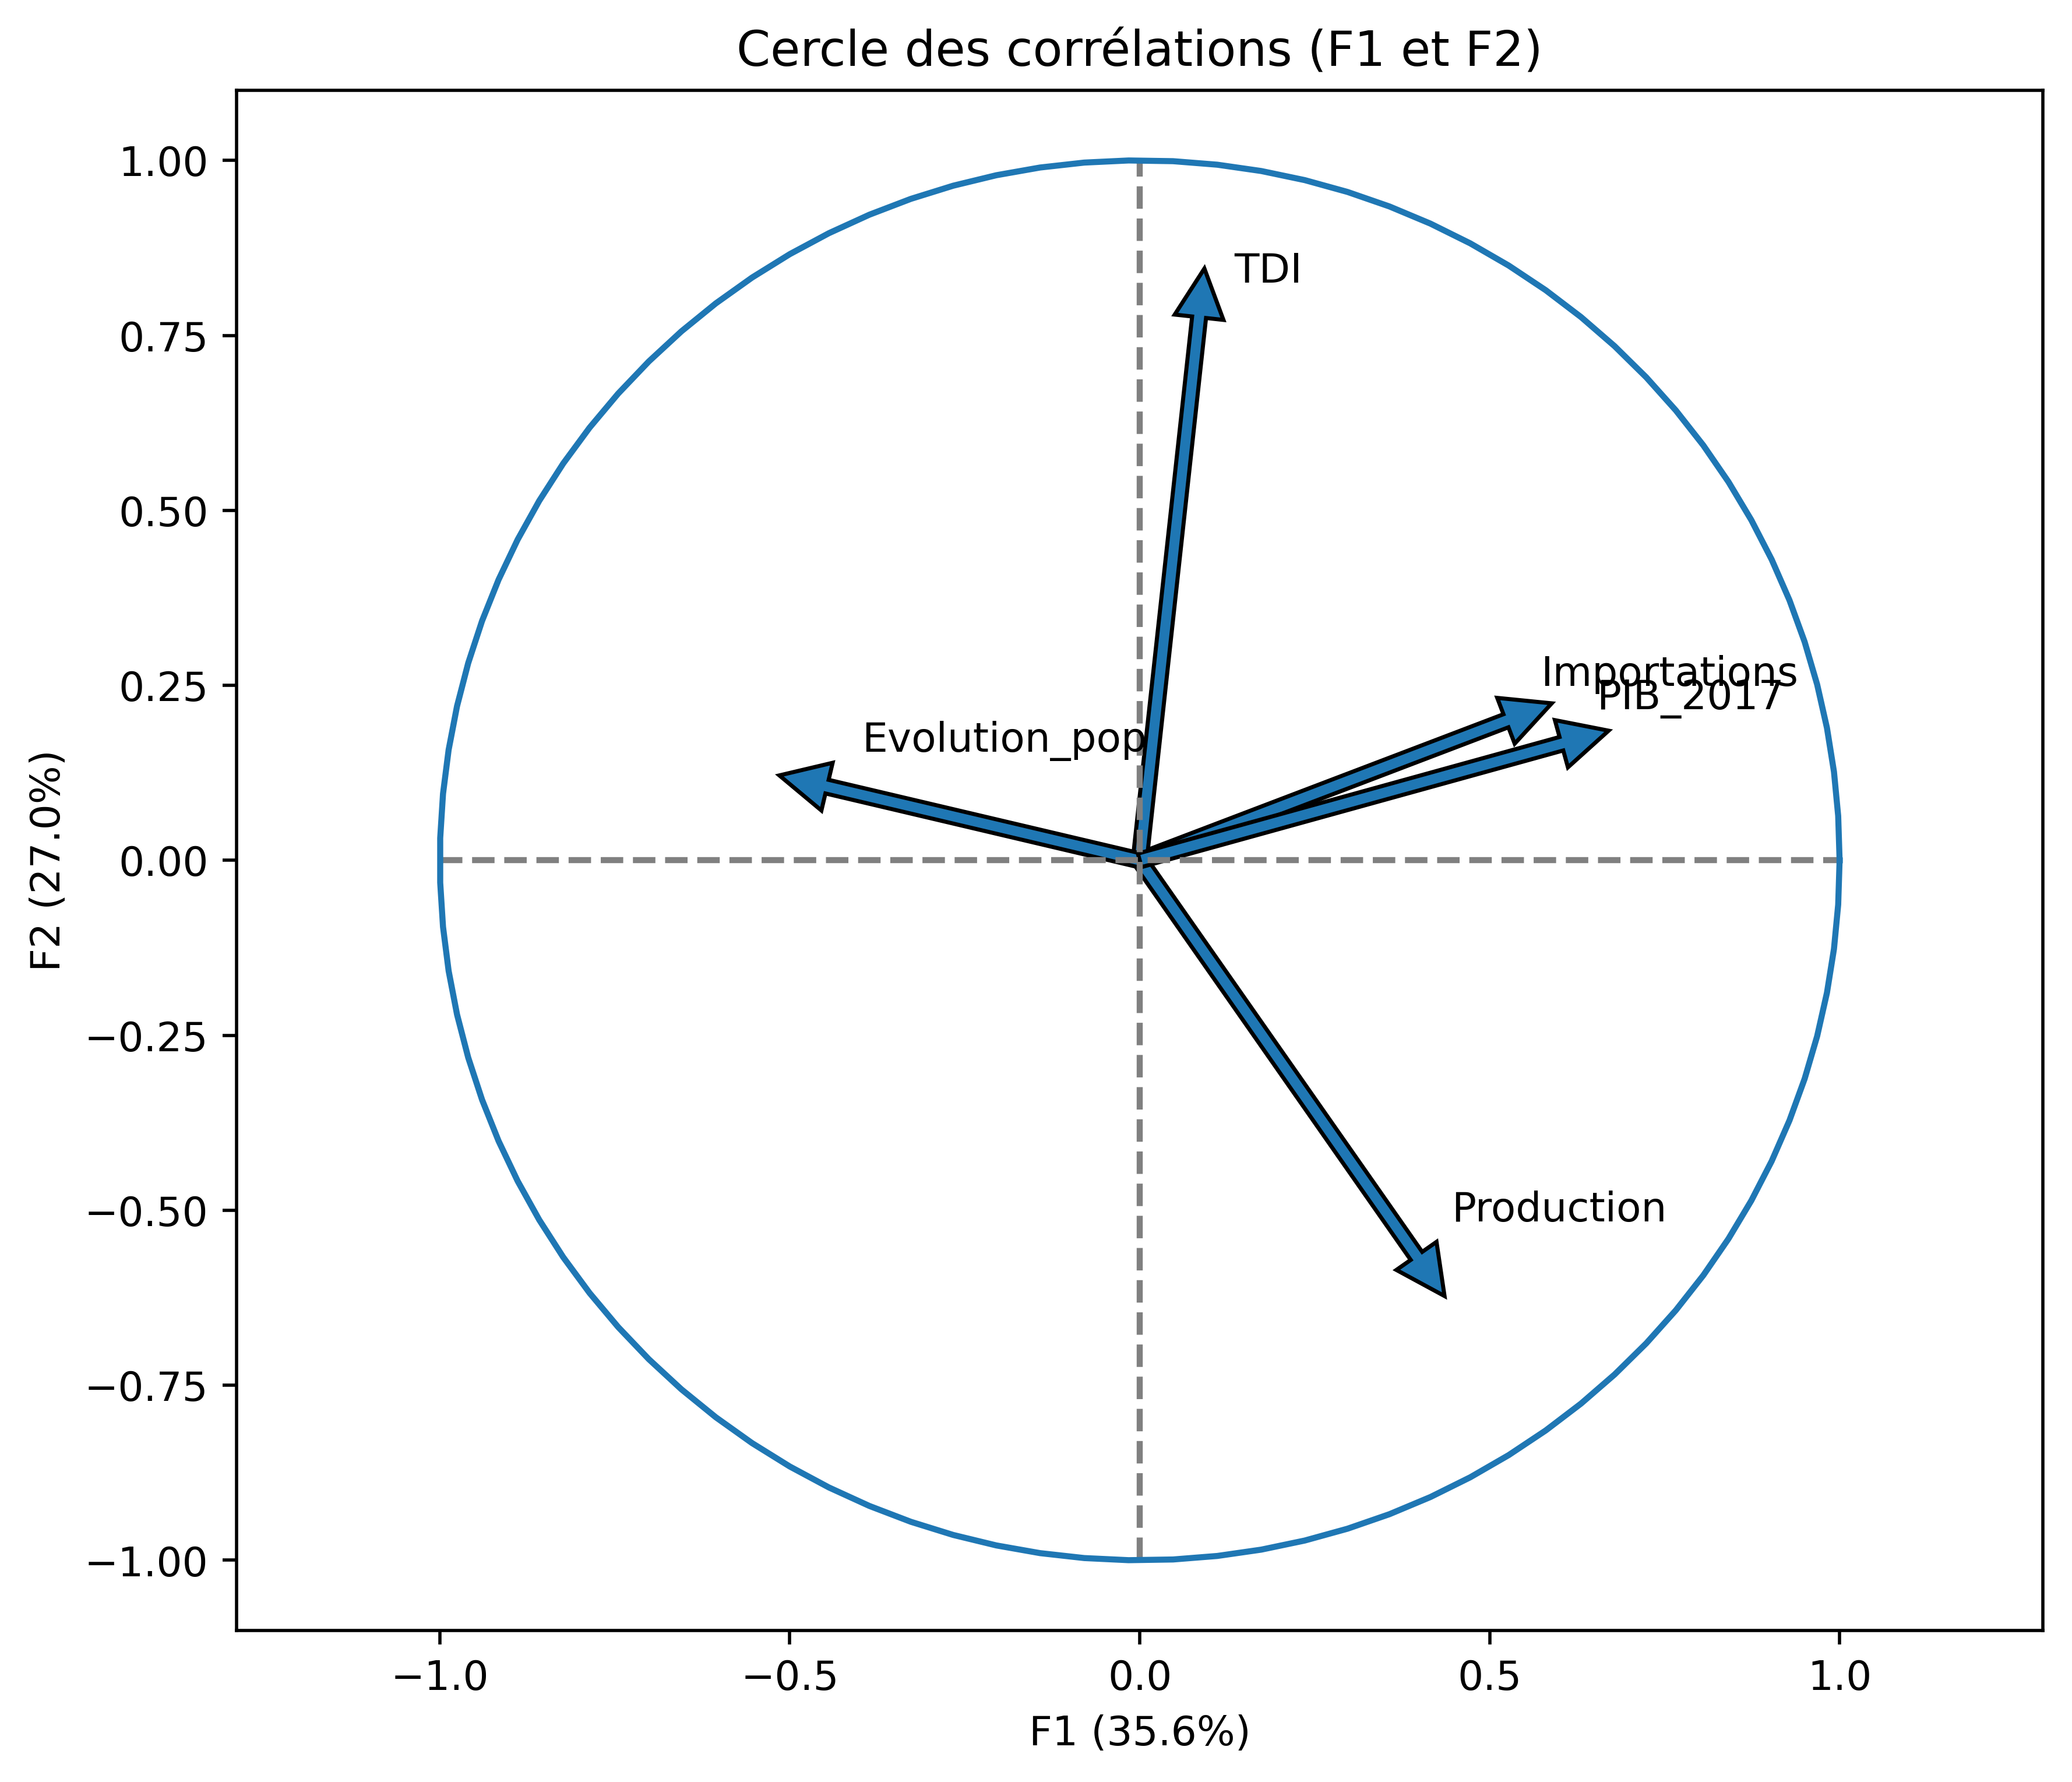

In [99]:
correlation_graph(pca, x_y, features)

Ici, on va en déduire que l'axe 1 oppose à droite les pays avec une forte valeur pour presque tous les indicateurs, et à droite les pays à faible valeur pourl'indicateur évolution de la population.

L'axe 2 semble opposer les pays avec une valeur positive pour les indicateurs: TDI, Importartions, PIB en 2017 et l'évolution de la population en haut, avec les pays avec une valeur négative pour la production en bas.

In [100]:
projected_df[["Dim1", "Dim2"]].to_csv('acp.csv', index=False)